In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

/anaconda/envs/onnx/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
num_samples = 1000

In [3]:
samples_df = pd.DataFrame({
    'coffee_p': np.cumsum(np.random.uniform(-1,1,(num_samples))),
    'oil_p': np.cumsum(np.random.uniform(-1,1,(num_samples))),
    'event_dummy': np.concatenate(
        ([0]*int(num_samples*1/4),
         [1]*int(num_samples*1/2), 
         [0]*int(num_samples*1/4)), axis=0)})

In [4]:
print(samples_df.shape)
samples_df.head()

(1000, 3)


,coffee_p,event_dummy,oil_p
0,0.163486,0,-0.965095
1,1.035005,0,-1.918513
2,1.623445,0,-2.048434
3,0.884828,0,-1.972109
4,0.457866,0,-2.686469


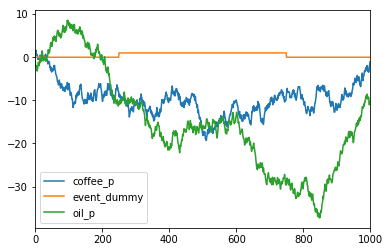

In [5]:
samples_df.plot()

In [6]:
# Regress coffee prices on event_dummy and oil prices
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [7]:
# Run OLS regresion
mod = sm.OLS(y, X)
res = mod.fit()

In [8]:
# Regression results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1935.
Date:                Tue, 28 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:07:24   Log-Likelihood:                -2964.8
No. Observations:                1000   AIC:                             5934.
Df Residuals:                     998   BIC:                             5943.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -7.0943      0.284    -24.954      0.000      -7.652      -6.536
x2             0.2683      0.011     25.291      0.000       0.247       0.289
==============================================================================
Omnibus:                       27.354   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.562
Skew:                          -0.379   Prob(JB):                     1.04e-06
Kurtosis:                       2.705   Cond. No.                         36.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-stat suggests that our results are strongly significant at the 0.001 level and we have a high R-squared value suggesting we can explain a lot of the y-variable with our data.

... But this data is just noise ...

The Durbin-Watson statistic is nearly 0, which suggests very strong serial auto-correlatoin, violating the assumptions for our OLS regression

**Let's try again but with first-difference**

In [9]:
samples_df_fd = pd.DataFrame({
    'coffee_p': samples_df[['coffee_p']].diff()[1:].values.squeeze(),
    'oil_p': samples_df[['oil_p']].diff()[1:].values.squeeze(),
    'event_dummy': samples_df[['event_dummy']][1:].values.squeeze()})

In [10]:
print(samples_df_fd.shape)
samples_df_fd.head()

(999, 3)


,coffee_p,event_dummy,oil_p
0,0.871519,0,-0.953417
1,0.588440,0,-0.129921
2,-0.738617,0,0.076325
3,-0.426962,0,-0.714360
4,-0.046145,0,0.358388


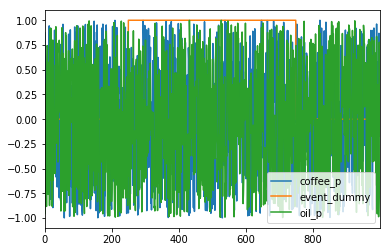

In [11]:
samples_df_fd.plot()

In [12]:
y = samples_df_fd['coffee_p'].values
X = samples_df_fd[['event_dummy', 'oil_p']].values
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1321
Date:                Tue, 28 Nov 2017   Prob (F-statistic):              0.876
Time:                        22:07:25   Log-Likelihood:                -867.90
No. Observations:                 999   AIC:                             1740.
Df Residuals:                     997   BIC:                             1750.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0030      0.026     -0.114      0.909      -0.054       0.048
x2            -0.0159      0.031     -0.506      0.613      -0.078       0.046
==============================================================================
Omnibus:                      574.381   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.772
Skew:                          -0.017   Prob(JB):                     4.70e-13
Kurtosis:                       1.833   Cond. No.                         1.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time we get the expected results, the explanatory variables are just random noise and explain nothing

**Instead of looking at the Durbin-Watson statistic to realise we had serial autocorrelation, could we have just done this?**

**Consider a standard machine-learning pipeline**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [14]:
# Our original data
y = samples_df['coffee_p'].values
X = samples_df[['event_dummy', 'oil_p']].values

In [15]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [16]:
# Run sklearn linear regression
reg = linear_model.LinearRegression()
reg.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
# Predict on test-data
prediction = reg.predict(X=X_test)

In [18]:
# What's the mean-squared-error
np.sum((y_test-prediction)**2)/len(prediction)

8.103469806113992

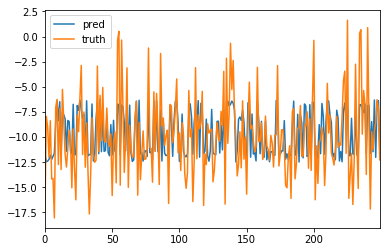

In [19]:
# Let's compare our prediction with the truth
test_df = pd.DataFrame({
    'truth': y_test,
    'pred': prediction})
test_df.plot()

**Did we learn to predict random-noise?**